### Importacion de Datos

In [133]:
import pandas as pd

data = pd.read_csv("databases/archive/diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Gráfica PCA

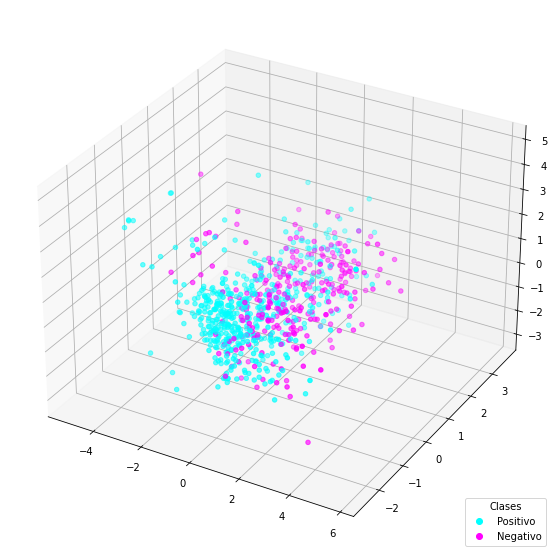

In [134]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

features = [i for i in data.columns != 'Outcome']
data_features = data.loc[:,features]
normalized_data_features = StandardScaler().fit_transform(x)

pca_function = PCA(n_components=3)
principalComponents = pca_function.fit_transform(normalized_data_features)

principalComponents_dataframe = pd.DataFrame(data=principalComponents, columns=['Principal Component 1'
    , 'Principal Component 2', 'Principal Component 3'])

fig = plt.figure(figsize=(10,10))   
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(principalComponents_dataframe.loc[:,'Principal Component 1']
                 , principalComponents_dataframe.loc[:,'Principal Component 2']
                , principalComponents_dataframe.loc[:,'Principal Component 3']
                ,c=data.loc[:,'Outcome'],cmap='cool')
fig = ax.legend(img.legend_elements()[0], ['Positivo', 'Negativo'], loc="lower right", title="Clases")

### Toma de muestras

In [135]:
import random as rm

def train_test_indexes(object_list):
    rm.shuffle(object_list)
    middle = int(len(object_list)/2)
    train_indexes=object_list[:middle]
    test_indexes=object_list[middle:]
    return train_indexes, test_indexes

ordered_data = data.sort_values('Outcome')
ordered_data = ordered_data.assign(Index=[i for i in range(ordered_data.shape[0])])

negatives_counts = (ordered_data.loc[:,'Outcome']==0).sum()
positives_counts = (ordered_data.loc[:,'Outcome']==1).sum()

negative_indexes = [i for i in range(negatives_counts)]
positive_indexes = [i for i in range(negatives_counts,(negatives_counts+positives_counts))]

train_indexes = []
test_indexes = []

train_aux, test_aux = train_test_indexes(negative_indexes)
train_indexes += train_aux
test_indexes += test_aux

train_aux, test_aux = train_test_indexes(positive_indexes)
train_indexes += train_aux
test_indexes += test_aux

train_indexes.sort()
test_indexes.sort()

In [136]:
train_data = ordered_data.loc[ordered_data['Index'].isin(train_indexes),:'Age']
test_data = ordered_data.loc[ordered_data['Index'].isin(test_indexes),:'Age']

test_true_outcomes = ordered_data.loc[ordered_data['Index'].isin(test_indexes),'Outcome']
train_true_outcomes = ordered_data.loc[ordered_data['Index'].isin(train_indexes),'Outcome']

### SVM

In [137]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

svm = SVC()
svm.fit(train_data, train_true_outcomes)
svm_predictions = svm.predict(test_data)
svm_precision = accuracy_score(train_true_outcomes, svm_predictions)
svm_precision

0.7369791666666666

### Logistic Regression

In [138]:
from sklearn.linear_model import LogisticRegression

logist = LogisticRegression(max_iter=2000)
logist.fit(train_data, train_true_outcomes)
logist_predictions = logist.predict(test_data)
logist_precision = accuracy_score(train_true_outcomes, logist_predictions)
logist_precision

0.7526041666666666

### Naive Bayes

In [139]:
from sklearn.naive_bayes import GaussianNB
bayes = GaussianNB()
bayes.fit(train_data, train_true_outcomes)
bayes_predictions=bayes.predict(test_data)
bayes_precision=accuracy_score(train_true_outcomes,bayes_predictions)
bayes_precision

0.7291666666666666

### Curvas ROC

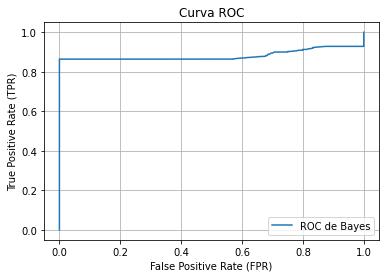

0.9119261993000725


In [141]:
def fpr_tpr(y_actual, y_hat):
    
    fpr =[]
    tpr=[]
    
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    
    fpr_aux = 0
    tpr_aux = 0
    
    for i in range(len(y_hat)): 
        tpr.append(tpr_aux)
        fpr.append(fpr_aux)
        if(y_hat[i] == y_actual[i]):
            if(y_actual[i] == 1):
                tp += 1
            else:
                fp += 1
        elif(y_hat[i] != y_actual[i]):
            if(y_actual[i] == 0):
                tn += 1
            else:
                fn += 1
        if((tp+fn)!=0):
            tpr_aux = tp/(tp+fn)
        if((tn+fp)!=0):
            fpr_aux = fp/(tn+fp)

    tpr = np.sort(tpr)
    fpr = np.sort(fpr)
    return [fpr,tpr]

def auc(roc_points):
    fpr_array = []
    tpr_array=[]

    for i in range(len(roc_points[0])-1):
        point1 = [roc_points[0][i], roc_points[1][i]]
        point2 = [roc_points[0][i+1], roc_points[1][i+1]]
        tpr_array.append([point1[0], point2[0]])
        fpr_array.append([point1[1], point2[1]])
    auc = sum(np.trapz(tpr_array,fpr_array))
    return auc

train_true_outcomes_arr = np.array(train_true_outcomes)
roc_data_bayes = fpr_tpr(train_true_outcomes_arr, bayes_predictions)

plt.plot(roc_data[1], roc_data[0], label='ROC de Bayes')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(auc(roc_data_bayes))